# HPA Gene Page AI Summaries

In [1]:
import pandas as pd
import json
from plotnine import *
import requests
import collections
from tqdm import tqdm
from extract_data import extract_multiple_genes
from visualization_utils import flatten_values, get_group, save_plot

## Extract Data

- Import gene ENSEMBLE IDs from HPA.
- For each gene ID, parse the corresponding HPA gene page and store it in JSON.

In [2]:
hpa_df = pd.read_csv("../data/hpa_genes.tsv", sep="\t")
hpa_genes = hpa_df.iloc[:, 0].tolist()

print(f"Loaded {len(hpa_genes)} genes from HPA file.")

Loaded 20162 genes from HPA file.


In [ ]:
# Extract data for all genes
if __name__ == "__main__":
    ensembl_ids = hpa_genes

    # Wrap the ensembl_ids with tqdm for progress tracking
    summaries = {}
    for gene_id in tqdm(ensembl_ids, desc="Processing genes", unit="gene"):
        try:
            result = extract_multiple_genes([gene_id])
            summaries.update(result)
        except Exception as e:
            summaries[gene_id] = {"_error": str(e)}

    # Save to file
    with open("../data/gene_data.json", "w") as f:
        json.dump(summaries, f, indent=2)

    print(json.dumps(summaries, indent=2))

'if __name__ == "__main__":\n    ensembl_ids = hpa_genes\n    summaries = extract_multiple_genes(ensembl_ids)\n    # Save to file\n    with open("../data/gene_data.json", "w") as f:\n        json.dump(summaries, f, indent=2)\n\n    for gene_json in summaries.values():\n        if "HUMAN PROTEIN ATLAS INFORMATION (brain)" in gene_json:\n            gene_json["Brain"] = gene_json.pop("HUMAN PROTEIN ATLAS INFORMATION (brain)")\n        if "HUMAN PROTEIN ATLAS INFORMATION (blood)" in gene_json:\n            gene_json["Blood"] = gene_json.pop("HUMAN PROTEIN ATLAS INFORMATION (blood)")\n\n    print(json.dumps(summaries, indent=2))'

## Exploratory Data Analysis

### Analyze all genes to identify distributions

In [3]:
with open("../data/gene_data.json") as f:
    gene_data = json.load(f)
    
print(f"Loaded data for {len(gene_data)} genes from JSON file.")

Loaded data for 20161 genes from JSON file.


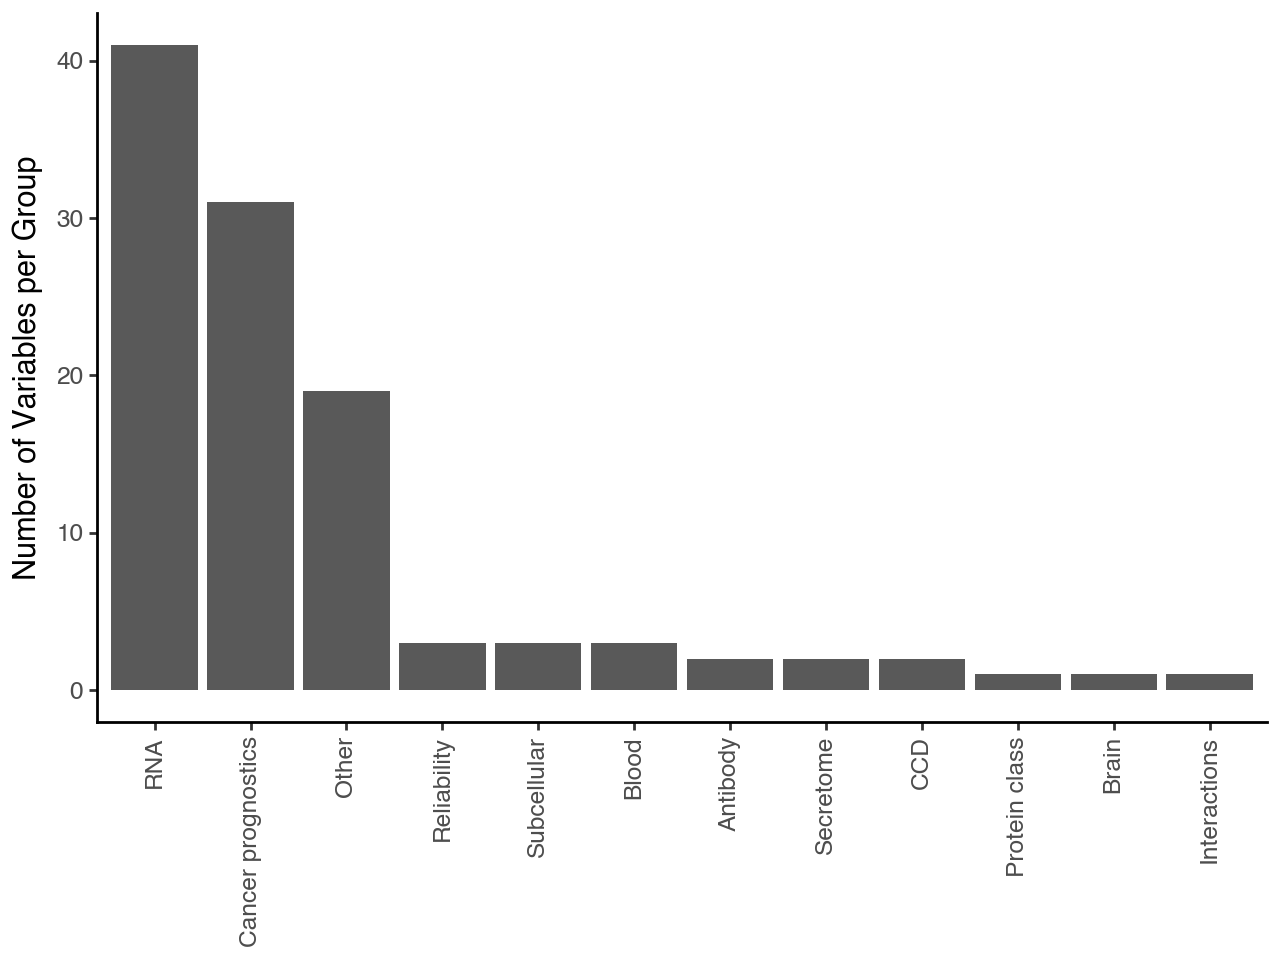

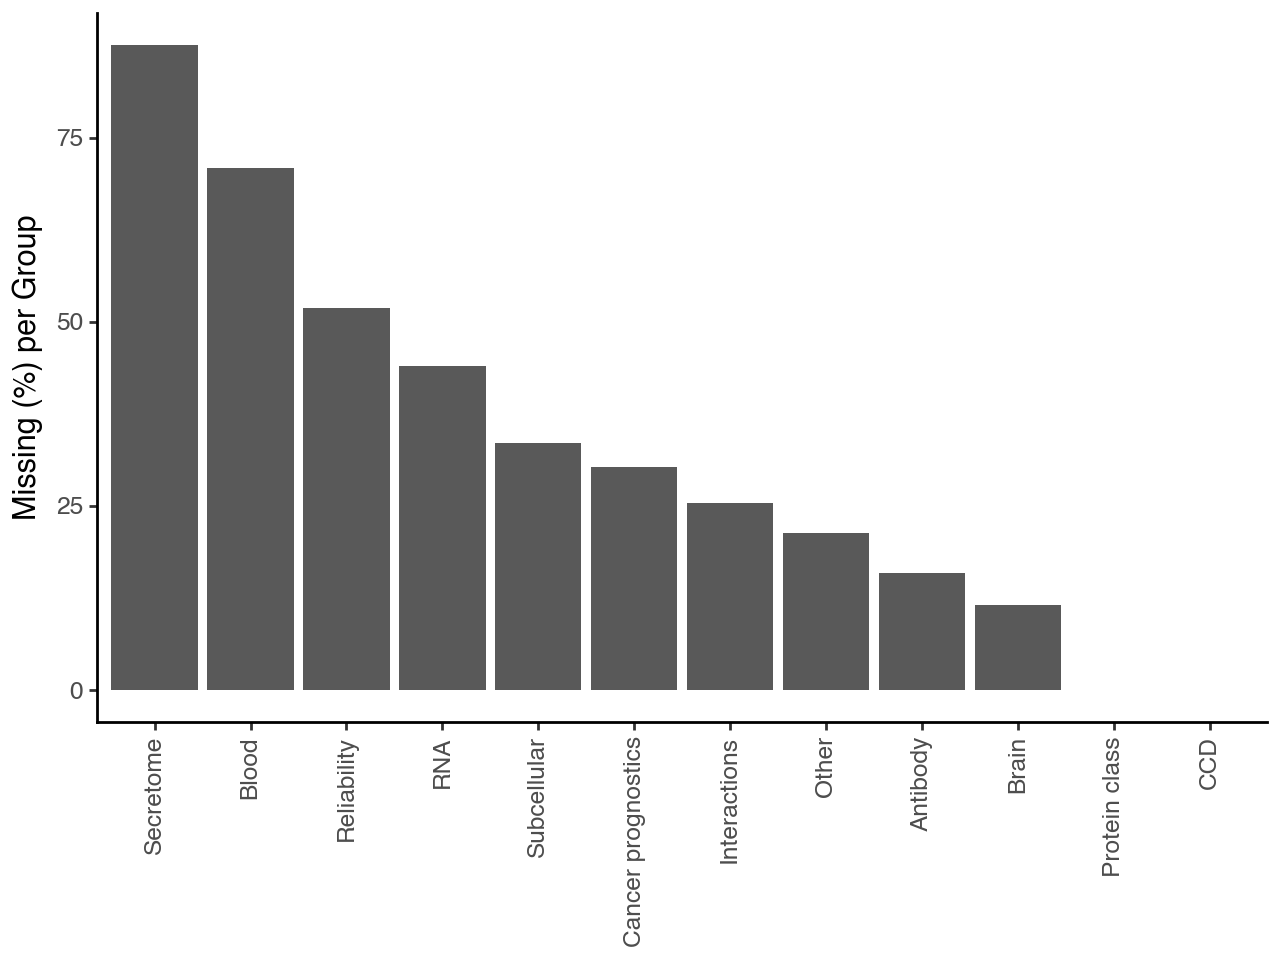

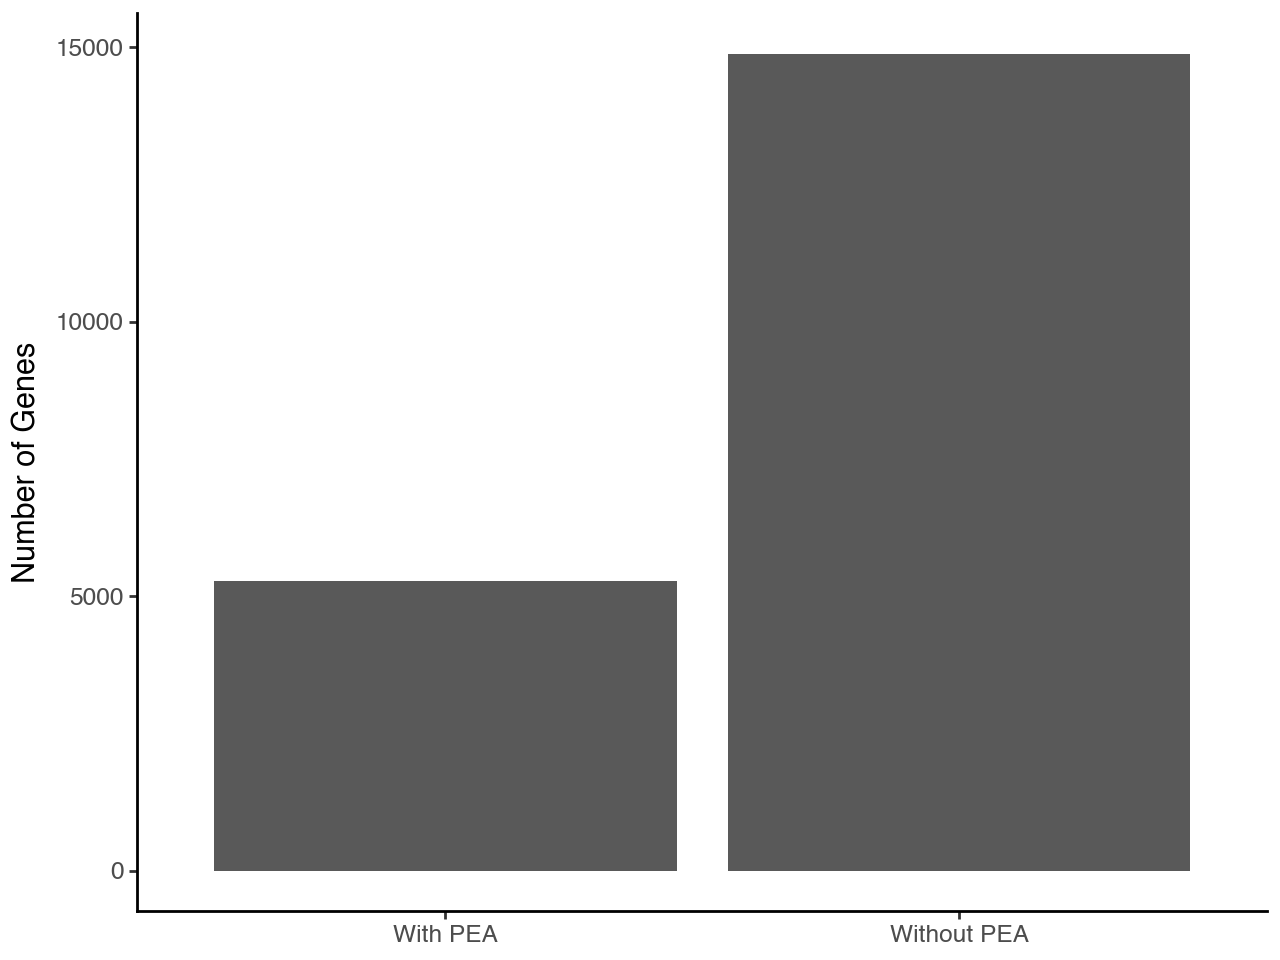

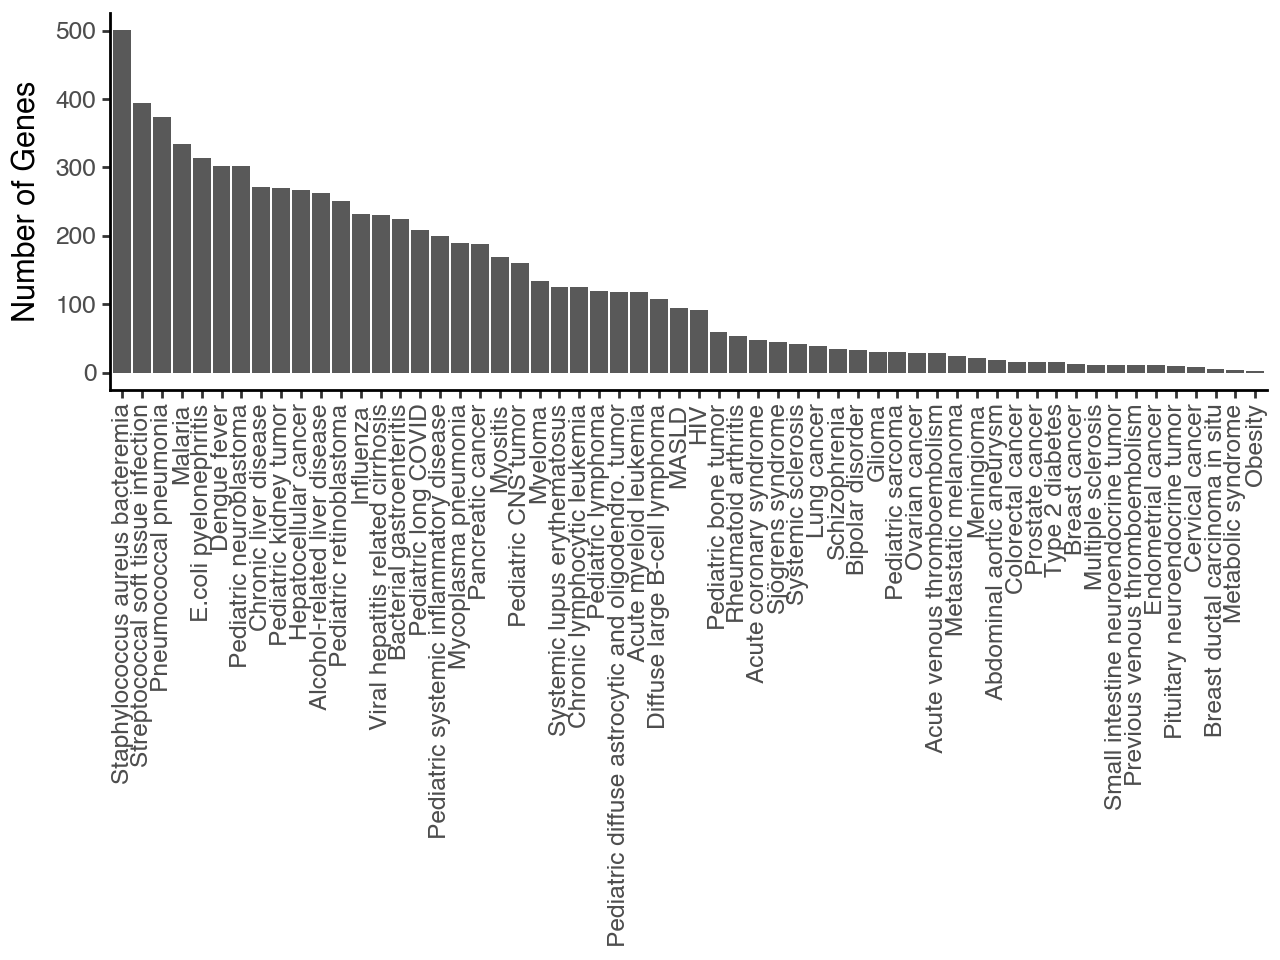

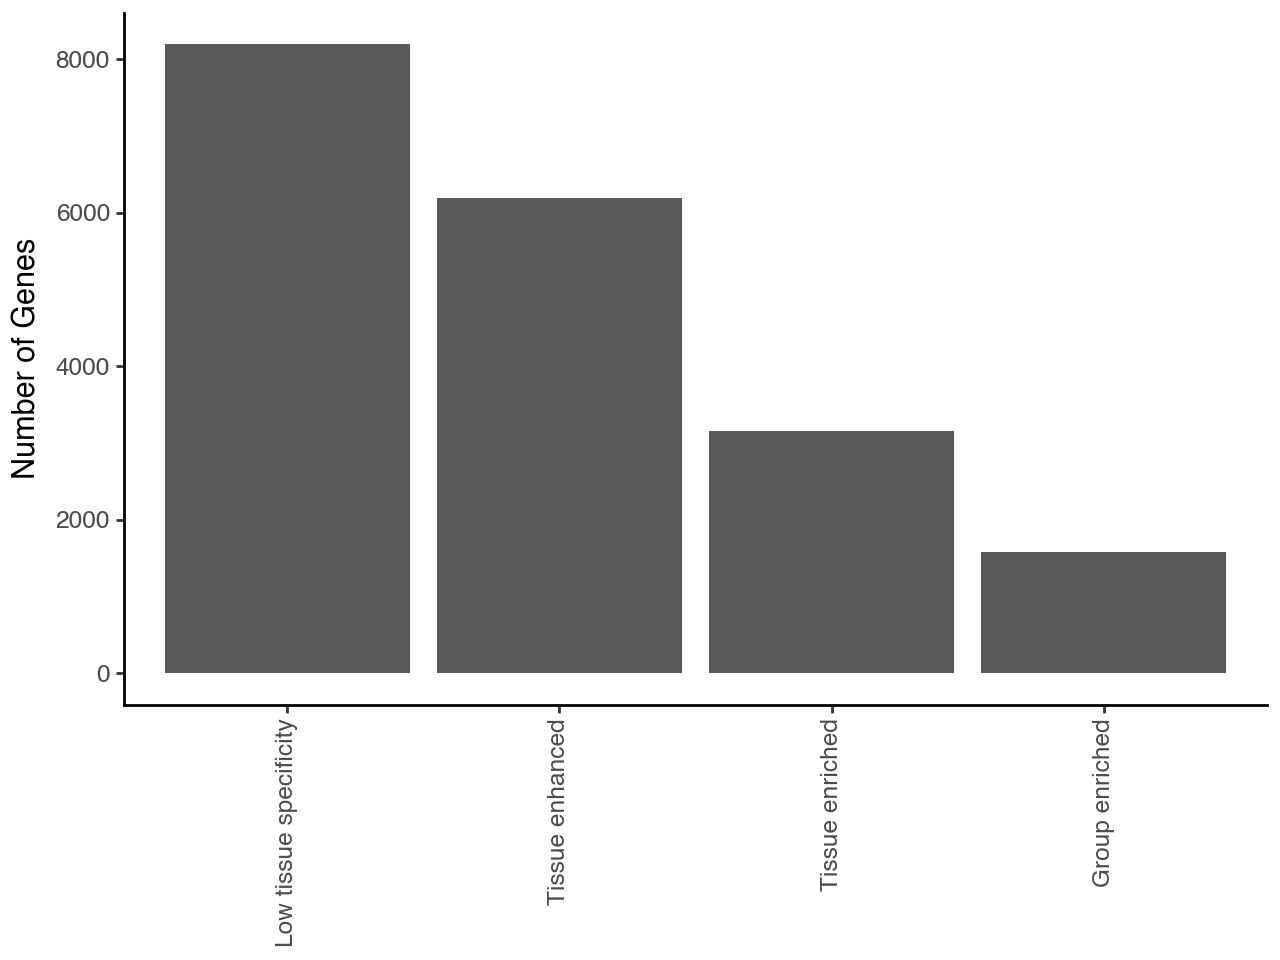

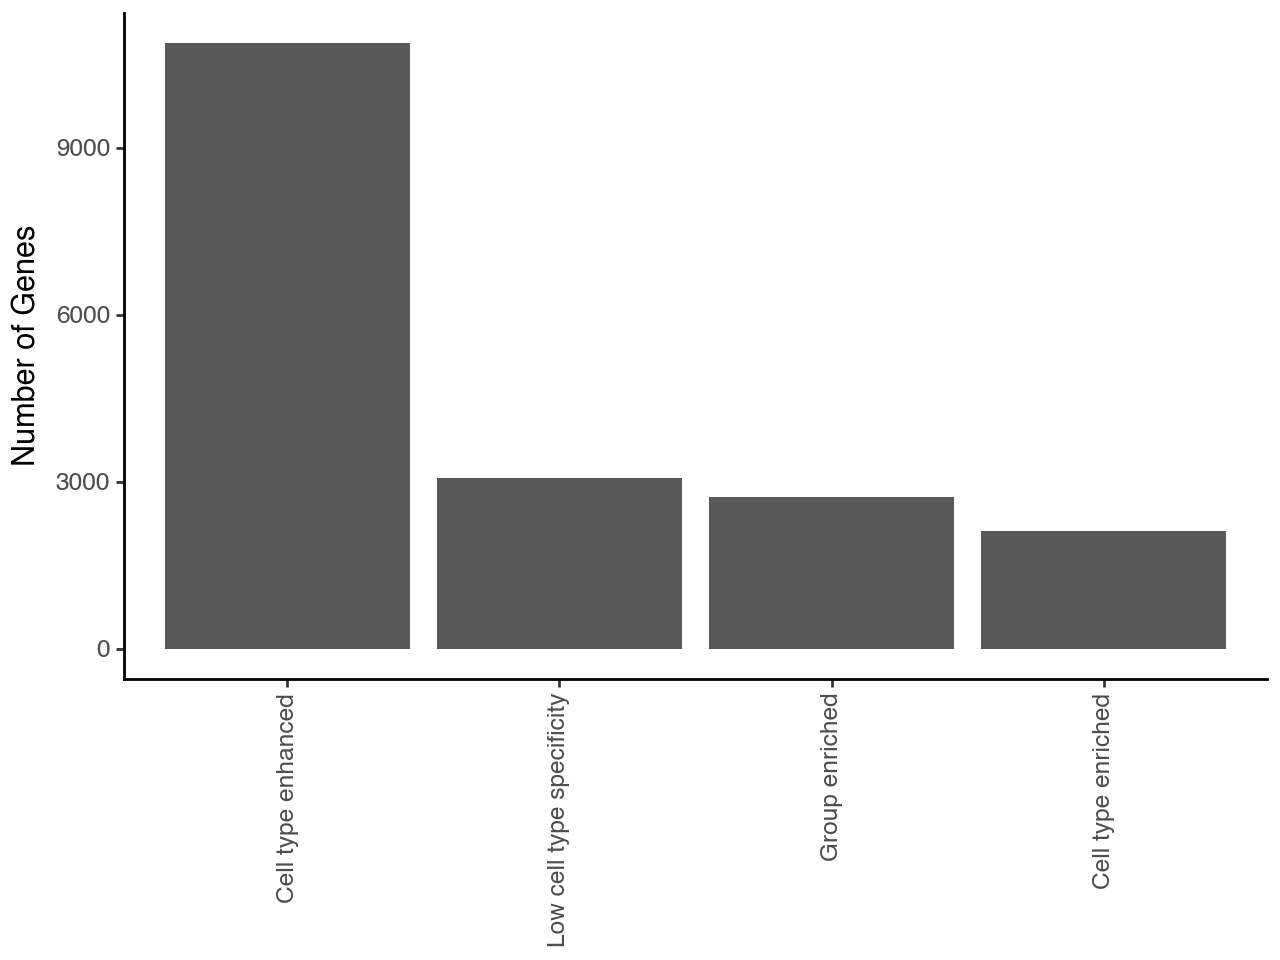

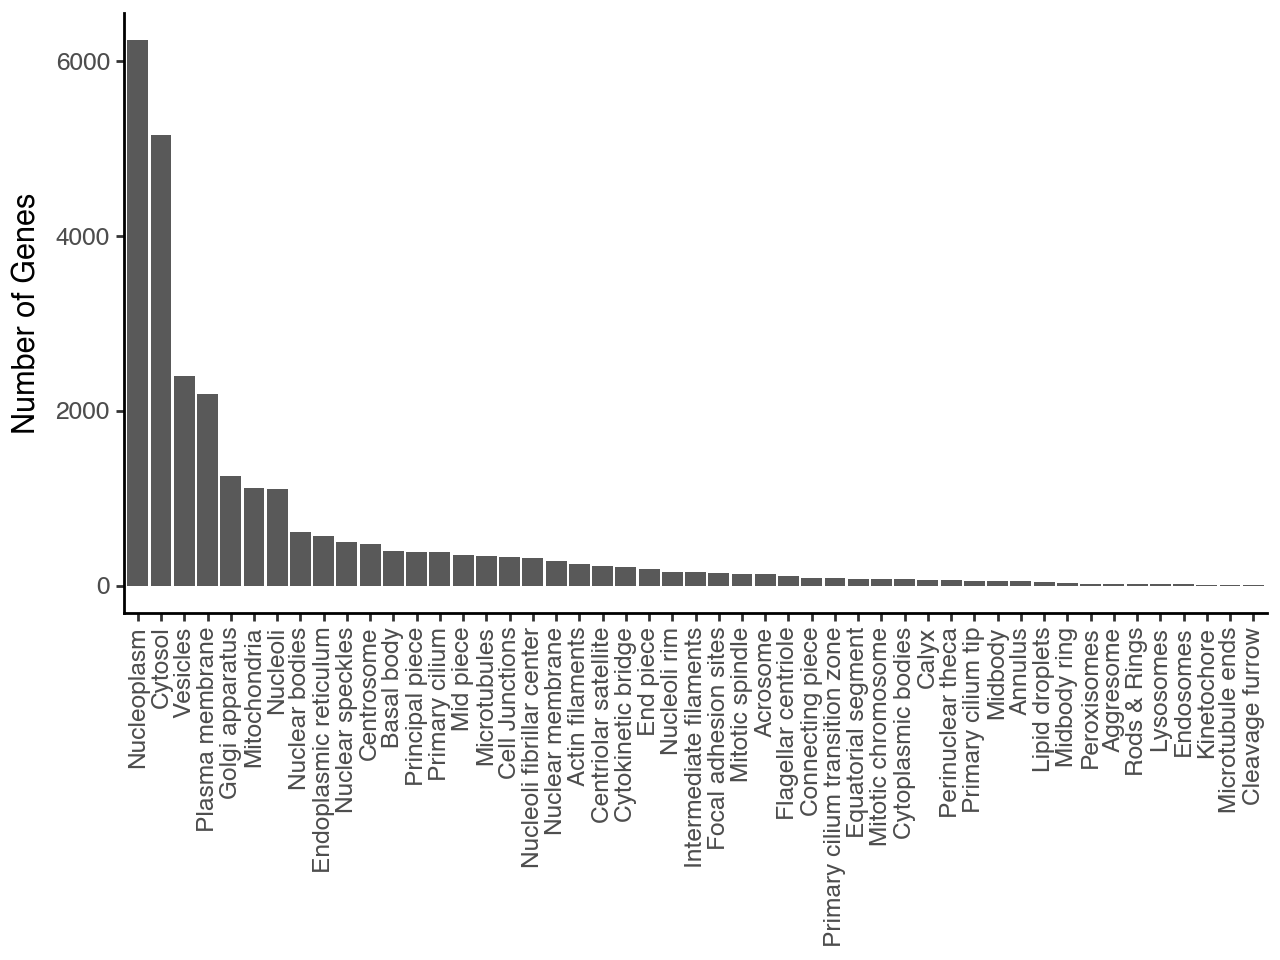

In [4]:
# Count unique fields per group
group_fields = collections.defaultdict(set)
for g in gene_data.values():
    for field in g.keys():
        group = get_group(field)
        group_fields[group].add(field)

# Prepare DataFrame
group_var_counts = pd.DataFrame([
    {"group": group, "num_variables": len(fields)}
    for group, fields in group_fields.items()
])
order_group_count = group_var_counts.sort_values("num_variables", ascending=False)["group"].tolist()

# Plot number of variables per group
p_vars = (
    ggplot(group_var_counts, aes(x="group", y="num_variables")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_group_count) +
    labs(x="", y="Number of Variables per Group") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_vars.show()

missing_counter = collections.defaultdict(int)
total_counter = collections.defaultdict(int)

for g in gene_data.values():
    for field, val in g.items():
        group = get_group(field)
        values = flatten_values(val)
        for v in values:
            total_counter[group] += 1
            if v is None or v == "" or v == [] or v == {} or v == "None" or v == "Not detected" or v == "Not analysed":
                missing_counter[group] += 1

# Calculate percentage missingness
missingness = []
for group in total_counter:
    percent = 100 * missing_counter[group] / total_counter[group] if total_counter[group] > 0 else 0
    missingness.append({"group": group, "missing_pct": percent})

missing_df = pd.DataFrame(missingness)
missing_order = missing_df.sort_values("missing_pct", ascending=False)["group"].tolist()

# Plot
p = (
    ggplot(missing_df, aes(x="group", y="missing_pct")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=missing_order) +
    labs(x="", y="Missing (%) per Group") +
    theme_classic() +
    theme(legend_position="none", axis_text_x=element_text(rotation=90, hjust=0.5))
)
p.show()

# PEA disease counts
pea_with = 0
pea_without = 0

for g in gene_data.values():
    blood_info = g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {})
    pea_status = blood_info.get("Proximity extension assay", "")
    if "Data available" in pea_status:
        pea_with += 1
    else:
        pea_without += 1

pea_df = pd.DataFrame({
    "PEA data": ["With PEA", "Without PEA"],
    "Count": [pea_with, pea_without]
})

p_pea = (
    ggplot(pea_df, aes(x="PEA data", y="Count")) +
    geom_bar(stat="identity") +
    labs(x="", y="Number of Genes") +
    theme_classic()
)
p_pea.show()

# Collect diseases for genes with PEA data
disease_counter = collections.Counter()
for g in gene_data.values():
    blood_info = g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {})
    pea_status = blood_info.get("Proximity extension assay", "")
    if "Data available" in pea_status:
        diseases = blood_info.get("Upregulated in disease", "")
        if diseases and diseases.lower() != "not analyzed" and diseases.lower() != "no":
            for disease in diseases.split(","):
                disease_counter[disease.strip()] += 1

# Prepare DataFrame for plotting
disease_df = pd.DataFrame({
    "Disease": list(disease_counter.keys()),
    "Count": list(disease_counter.values())
}).sort_values("Count", ascending=False)

disease_order = disease_df["Disease"].tolist()

p_disease = (
    ggplot(disease_df, aes(x="Disease", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=disease_order) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_disease.show()

# Tissue counts
tissue_specificity_counter = collections.Counter()
tissue_ntpm_counter = collections.Counter()

for g in gene_data.values():
    # RNA tissue specificity
    spec = g.get('RNA tissue specificity', None)
    if spec and spec.lower() != "not detected":
        tissue_specificity_counter[spec] += 1
    # RNA tissue specific nTPM
    ntpm = g.get('RNA tissue specific nTPM', {})
    if isinstance(ntpm, dict):
        for tissue in ntpm:
            tissue_ntpm_counter[tissue] += 1

# Plot tissue specificity
df_tissue_spec = pd.DataFrame({
    "Specificity": list(tissue_specificity_counter.keys()),
    "Count": list(tissue_specificity_counter.values())
}).sort_values("Count", ascending=False)
order_tissue_spec = df_tissue_spec["Specificity"].tolist()

p_tissue_spec = (
    ggplot(df_tissue_spec, aes(x="Specificity", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_tissue_spec) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_tissue_spec.show()

# Cell type counts
celltype_specificity_counter = collections.Counter()
celltype_ntpm_counter = collections.Counter()

for g in gene_data.values():
    # RNA single cell type specificity
    spec = g.get('RNA single cell type specificity', None)
    if spec and spec.lower() != "not detected":
        celltype_specificity_counter[spec] += 1
    # RNA single cell type specific nTPM
    ntpm = g.get('RNA single cell type specific nTPM', {})
    if isinstance(ntpm, dict):
        for celltype in ntpm:
            celltype_ntpm_counter[celltype] += 1

# Plot cell type specificity
df_celltype_spec = pd.DataFrame({
    "Specificity": list(celltype_specificity_counter.keys()),
    "Count": list(celltype_specificity_counter.values())
}).sort_values("Count", ascending=False)
order_celltype_spec = df_celltype_spec["Specificity"].tolist()

p_celltype_spec = (
    ggplot(df_celltype_spec, aes(x="Specificity", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_celltype_spec) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_celltype_spec.show()

# Subcellular location
subcellular_counter = collections.Counter()
for g in gene_data.values():
    locations = g.get('Subcellular location', [])
    if isinstance(locations, list):
        for loc in locations:
            subcellular_counter[loc] += 1

df_subcellular = pd.DataFrame({
    "Location": list(subcellular_counter.keys()),
    "Count": list(subcellular_counter.values())
}).sort_values("Count", ascending=False)
order_subcellular = df_subcellular["Location"].tolist()

p_subcellular = (
    ggplot(df_subcellular, aes(x="Location", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_subcellular) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_subcellular.show()

In [5]:
# Save plots for all genes data
save_plot(p_vars, "../results/plots/number_of_variables_per_group.pdf")
save_plot(p, "../results/plots/missingness_percentage_per_group.pdf")
save_plot(p_pea, "../results/plots/pea_data_distribution.pdf")
save_plot(p_disease, "../results/plots/disease_distribution.pdf")
save_plot(p_tissue_spec, "../results/plots/tissue_specificity.pdf")
save_plot(p_celltype_spec, "../results/plots/cell_type_specificity.pdf")
save_plot(p_subcellular, "../results/plots/subcellular_location_distribution.pdf")

print("All plots have been saved as square-shaped PDFs.")

/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../results/plots/number_of_variables_per_group.pdf
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../results/plots/missingness_percentage_per_group.pdf
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summ

All plots have been saved as square-shaped PDFs.


/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../results/plots/tissue_specificity.pdf
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../results/plots/cell_type_specificity.pdf
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/s

Subsample based on the distributions found in the exploratory data analysis for diseases and PEA data existence, subcellular location, tissue and cell type specificity as well as expression levels.

In [6]:
gene_df = pd.DataFrame.from_dict(gene_data, orient="index")

# Stratification rules
gene_df['PEA_status'] = gene_df.apply(
    lambda g: "With PEA" if "Data available" in (g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {}).get("Proximity extension assay", "")) else "Without PEA",
    axis=1
)

gene_df['Disease'] = gene_df.apply(
    lambda g: g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {}).get("Upregulated in disease", "None").split(",")[0] if g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {}).get("Upregulated in disease", "None") not in ["Not analyzed", "no", "None"] else "None",
    axis=1
)

gene_df['Tissue_specificity'] = gene_df.apply(
    lambda g: g.get("RNA tissue specificity", "Unknown"),
    axis=1
)

gene_df['Cell_type_specificity'] = gene_df.apply(
    lambda g: g.get("RNA single cell type specificity", "Unknown"),
    axis=1
)

gene_df['Subcellular_location'] = gene_df.apply(
    lambda g: g.get("Subcellular location", ["Unknown"])[0] if isinstance(g.get("Subcellular location", []), list) else "Unknown",
    axis=1
)

gene_df['Num_diseases'] = gene_df.apply(
    lambda g: len(g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {}).get("Upregulated in disease", "").split(",")) 
    if "Data available" in g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {}).get("Proximity extension assay", "") else 0,
    axis=1
)

gene_df['Stratify_group'] = gene_df['PEA_status'] + "|" + gene_df['Disease'] + "|" + gene_df['Tissue_specificity'] + "|" + gene_df['Cell_type_specificity'] + "|" + gene_df['Subcellular_location']

# Separate genes with PEA data and broad disease distribution
pea_genes = gene_df[(gene_df['PEA_status'] == "With PEA") & (gene_df['Num_diseases'] > 1)]
non_pea_genes = gene_df[gene_df['PEA_status'] == "Without PEA"]

num_pea_samples = int(0.75 * 100)  # 75% of the samples have PEA data
num_non_pea_samples = 100 - num_pea_samples  # The rest without PEA data


sampled_pea_genes = pea_genes.sample(n=min(num_pea_samples, len(pea_genes)), random_state=42)
sampled_non_pea_genes = non_pea_genes.sample(n=min(num_non_pea_samples, len(non_pea_genes)), random_state=42)
sampled_df = pd.concat([sampled_pea_genes, sampled_non_pea_genes])

# More samples are needed: random sampling
remaining_samples = 100 - len(sampled_df)
if remaining_samples > 0:
    remaining_genes = gene_df[~gene_df.index.isin(sampled_df.index)]
    additional_samples = remaining_genes.sample(n=remaining_samples, random_state=42)
    sampled_df = pd.concat([sampled_df, additional_samples])

sampled_genes_dict = sampled_df.to_dict(orient="index")
with open("../data/sampled_genes.json", "w") as f:
    json.dump(sampled_genes_dict, f, indent=2)

print(f"Sampled {len(sampled_genes_dict)} genes.")

# Verify the distribution of PEA data and diseases in the sampled dataset
sampled_pea_counts = sampled_df['PEA_status'].value_counts()
sampled_disease_counts = sampled_df['Num_diseases'].value_counts()
print("PEA Status Distribution in Sampled Data:")
print(sampled_pea_counts)
print("Disease Distribution in Sampled Data:")
print(sampled_disease_counts)

Sampled 100 genes.
PEA Status Distribution in Sampled Data:
PEA_status
With PEA       75
Without PEA    25
Name: count, dtype: int64
Disease Distribution in Sampled Data:
Num_diseases
0     25
3     14
2      9
6      9
4      7
13     4
7      4
11     3
8      3
5      3
15     3
9      3
14     2
10     2
17     2
16     2
21     1
23     1
19     1
18     1
25     1
Name: count, dtype: int64


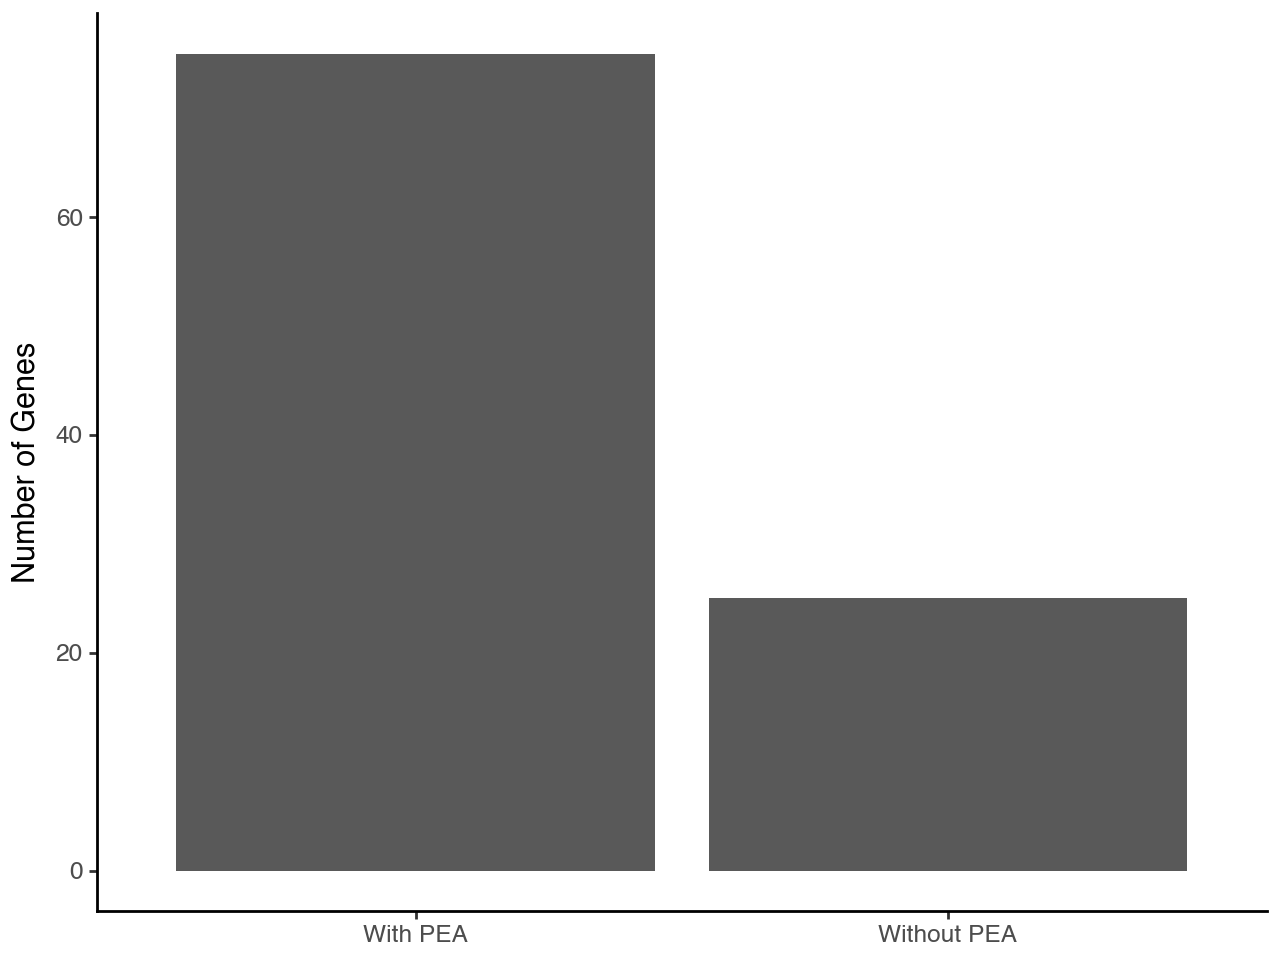

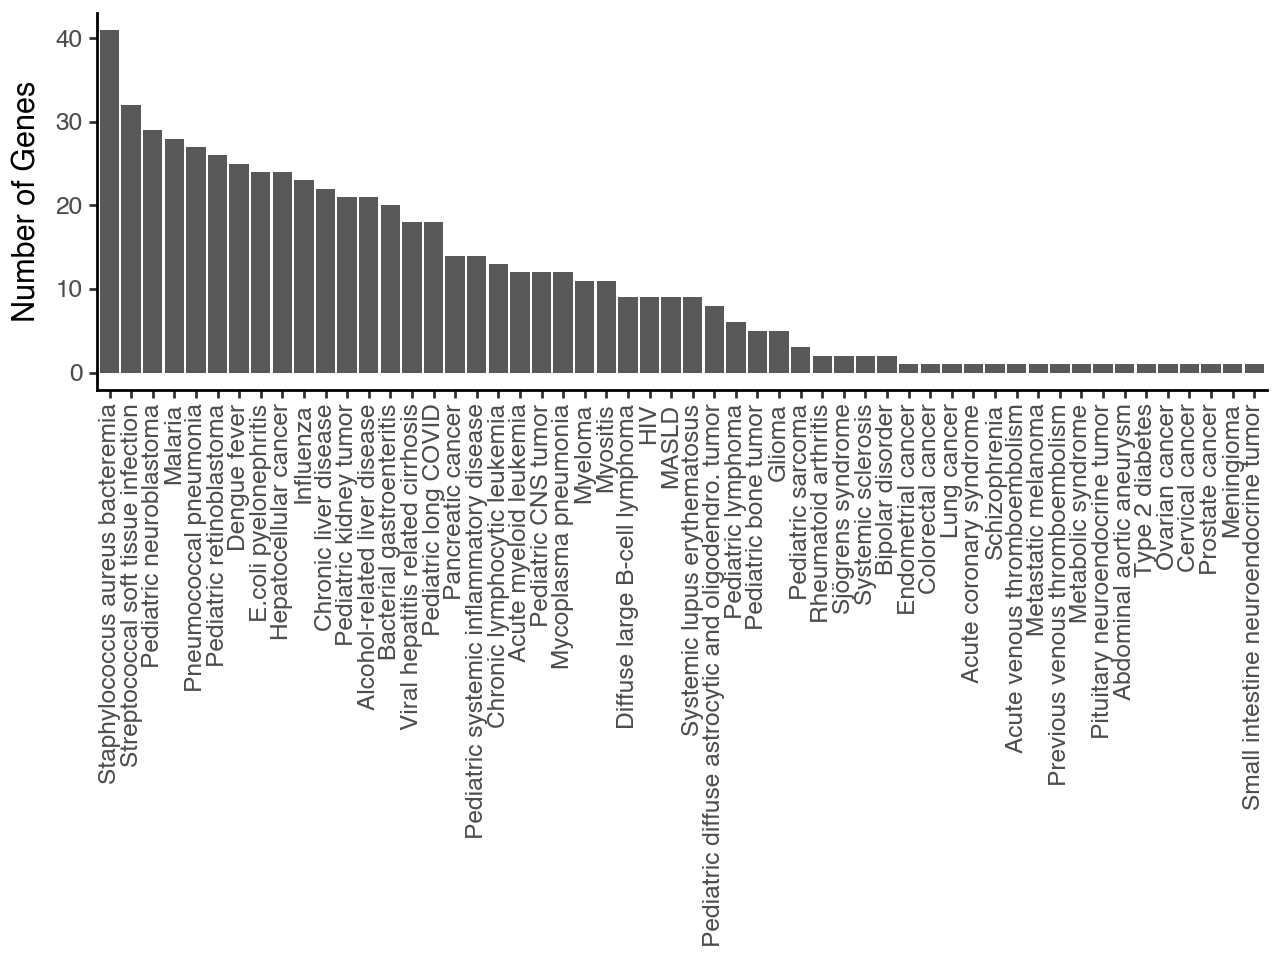

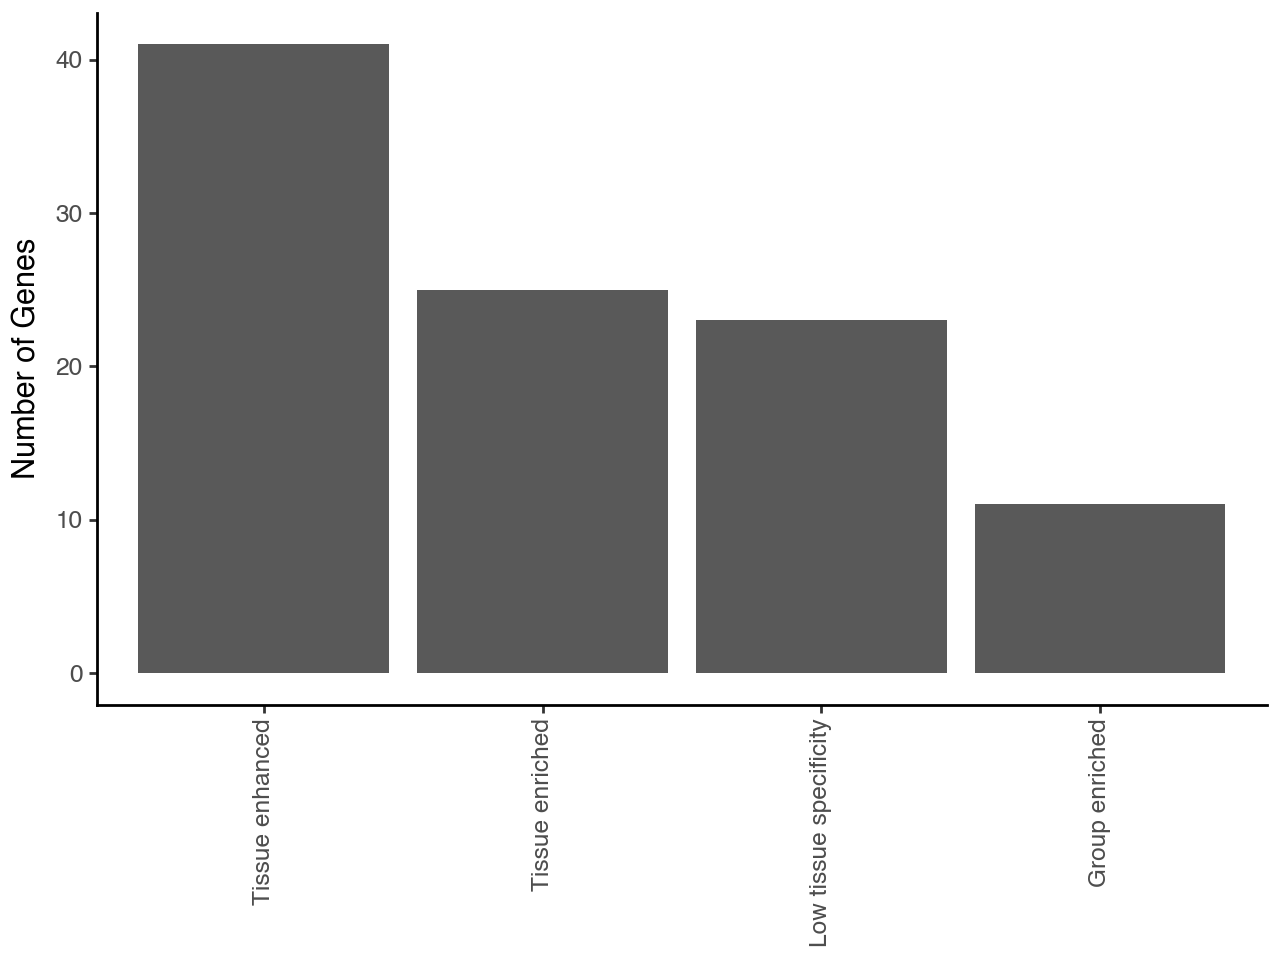

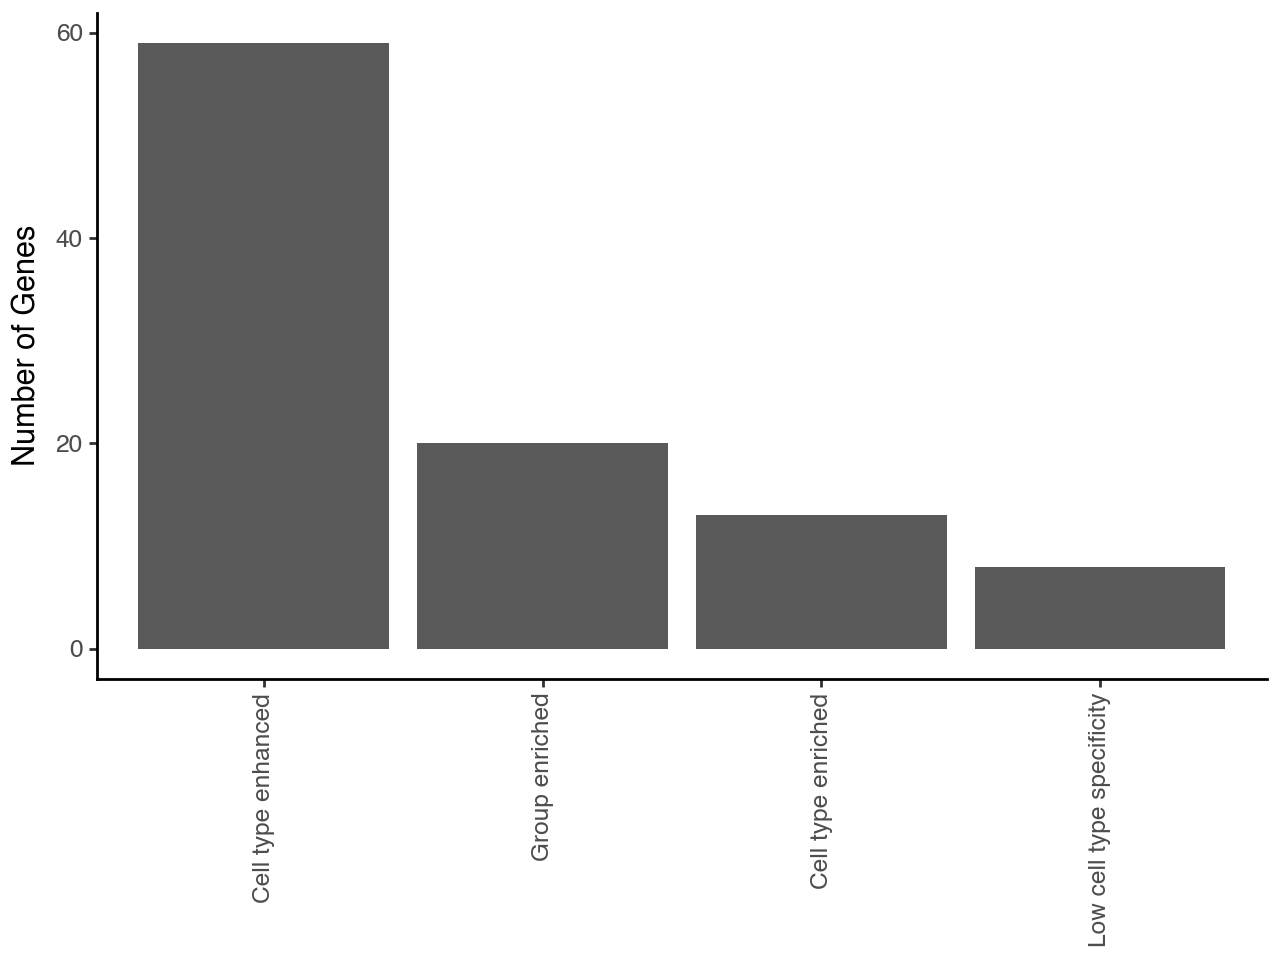

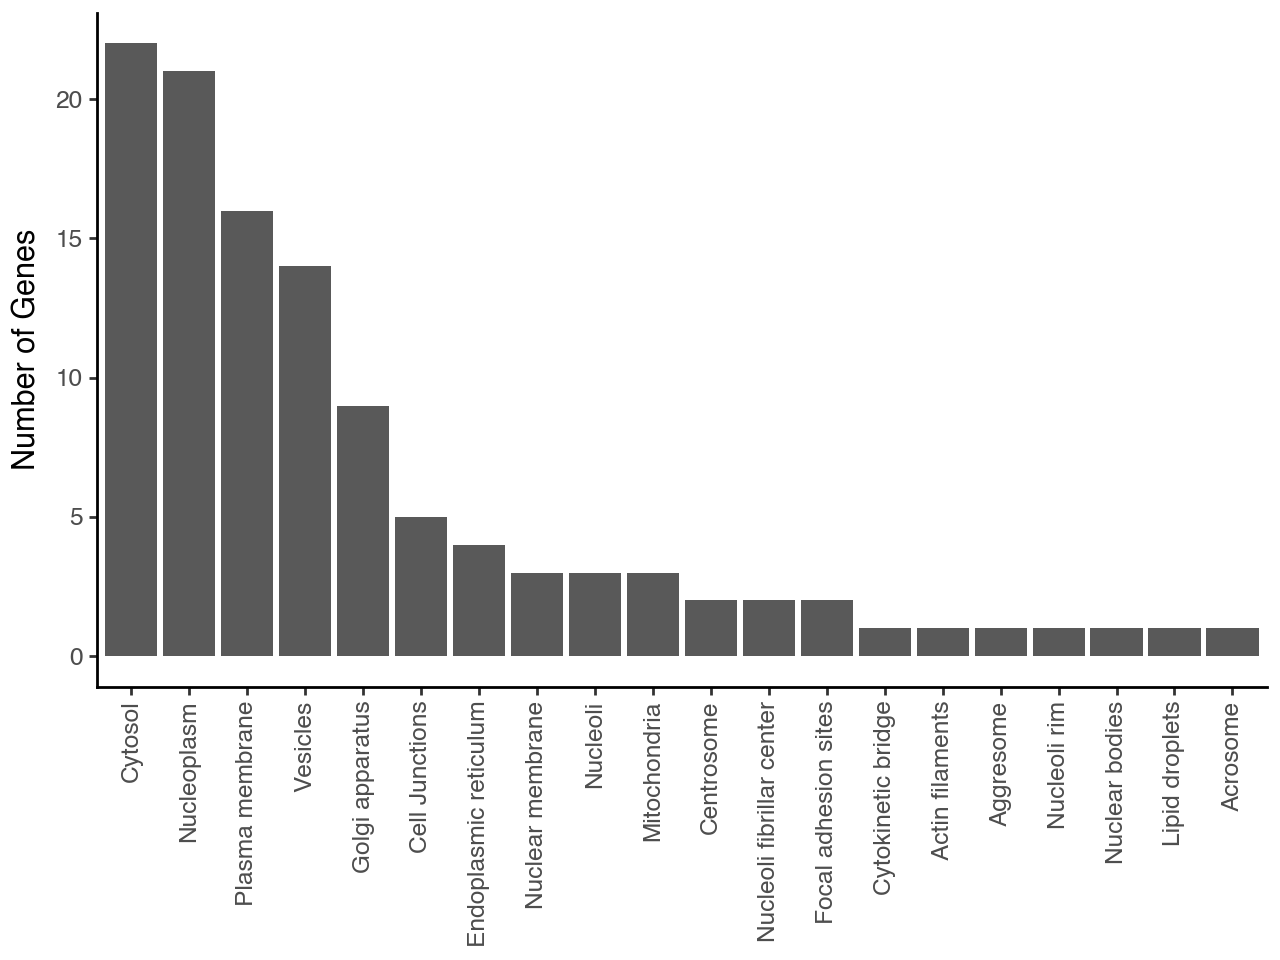

In [7]:
gene_data = sampled_genes_dict

# PEA disease counts
pea_with = 0
pea_without = 0

for g in gene_data.values():
    blood_info = g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {})
    pea_status = blood_info.get("Proximity extension assay", "")
    if "Data available" in pea_status:
        pea_with += 1
    else:
        pea_without += 1

pea_df = pd.DataFrame({
    "PEA data": ["With PEA", "Without PEA"],
    "Count": [pea_with, pea_without]
})

p_pea_sub = (
    ggplot(pea_df, aes(x="PEA data", y="Count")) +
    geom_bar(stat="identity") +
    labs(x="", y="Number of Genes") +
    theme_classic()
)
p_pea_sub.show()

# Collect diseases for genes with PEA data
disease_counter = collections.Counter()
for g in gene_data.values():
    blood_info = g.get("HUMAN PROTEIN ATLAS INFORMATION (blood)", {})
    pea_status = blood_info.get("Proximity extension assay", "")
    if "Data available" in pea_status:
        diseases = blood_info.get("Upregulated in disease", "")
        if diseases and diseases.lower() != "not analyzed" and diseases.lower() != "no":
            for disease in diseases.split(","):
                disease_counter[disease.strip()] += 1

# Prepare DataFrame for plotting
disease_df = pd.DataFrame({
    "Disease": list(disease_counter.keys()),
    "Count": list(disease_counter.values())
}).sort_values("Count", ascending=False)

disease_order = disease_df["Disease"].tolist()

p_disease_sub = (
    ggplot(disease_df, aes(x="Disease", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=disease_order) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_disease_sub.show()

# Tissue counts
tissue_specificity_counter = collections.Counter()
tissue_ntpm_counter = collections.Counter()

for g in gene_data.values():
    # RNA tissue specificity
    spec = g.get('RNA tissue specificity', None)
    if spec and spec.lower() != "not detected":
        tissue_specificity_counter[spec] += 1
    # RNA tissue specific nTPM
    ntpm = g.get('RNA tissue specific nTPM', {})
    if isinstance(ntpm, dict):
        for tissue in ntpm:
            tissue_ntpm_counter[tissue] += 1

# Plot tissue specificity
df_tissue_spec = pd.DataFrame({
    "Specificity": list(tissue_specificity_counter.keys()),
    "Count": list(tissue_specificity_counter.values())
}).sort_values("Count", ascending=False)
order_tissue_spec = df_tissue_spec["Specificity"].tolist()

p_tissue_spec_sub = (
    ggplot(df_tissue_spec, aes(x="Specificity", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_tissue_spec) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_tissue_spec_sub.show()

# Cell type counts
celltype_specificity_counter = collections.Counter()
celltype_ntpm_counter = collections.Counter()

for g in gene_data.values():
    # RNA single cell type specificity
    spec = g.get('RNA single cell type specificity', None)
    if spec and spec.lower() != "not detected":
        celltype_specificity_counter[spec] += 1
    # RNA single cell type specific nTPM
    ntpm = g.get('RNA single cell type specific nTPM', {})
    if isinstance(ntpm, dict):
        for celltype in ntpm:
            celltype_ntpm_counter[celltype] += 1

# Plot cell type specificity
df_celltype_spec = pd.DataFrame({
    "Specificity": list(celltype_specificity_counter.keys()),
    "Count": list(celltype_specificity_counter.values())
}).sort_values("Count", ascending=False)
order_celltype_spec = df_celltype_spec["Specificity"].tolist()

p_celltype_spec_sub = (
    ggplot(df_celltype_spec, aes(x="Specificity", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_celltype_spec) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_celltype_spec_sub.show()

# Subcellular location
subcellular_counter = collections.Counter()
for g in gene_data.values():
    locations = g.get('Subcellular location', [])
    if isinstance(locations, list):
        for loc in locations:
            subcellular_counter[loc] += 1

df_subcellular = pd.DataFrame({
    "Location": list(subcellular_counter.keys()),
    "Count": list(subcellular_counter.values())
}).sort_values("Count", ascending=False)
order_subcellular = df_subcellular["Location"].tolist()

p_subcellular_sub = (
    ggplot(df_subcellular, aes(x="Location", y="Count")) +
    geom_bar(stat="identity") +
    scale_x_discrete(limits=order_subcellular) +
    labs(x="", y="Number of Genes") +
    theme_classic() +
    theme(axis_text_x=element_text(rotation=90, hjust=0.5))
)
p_subcellular_sub.show()

In [8]:
# Save plots for subsetted data
save_plot(p_pea_sub, "../results/plots/pea_data_distribution_sub.pdf")
save_plot(p_disease_sub, "../results/plots/disease_distribution_sub.pdf")
save_plot(p_tissue_spec_sub, "../results/plots/tissue_specificity_sub.pdf")
save_plot(p_celltype_spec_sub, "../results/plots/cell_type_specificity_sub.pdf")
save_plot(p_subcellular_sub, "../results/plots/subcellular_location_distribution_sub.pdf")

print("All plots have been saved as square-shaped PDFs.")

/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../results/plots/pea_data_distribution_sub.pdf
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: ../results/plots/disease_distribution_sub.pdf
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/python3.13/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6 x 6 in image.
/Users/kostasantonopoulos/Documents/PhD courses/DDLS course/hpa-ai-summaries/lib/py

All plots have been saved as square-shaped PDFs.


## Baseline Model

In [14]:
def baseline_gene_summary(gene_json):
    """
    Calls a local LLM API to generate a summary for a gene given its JSON data.
    """
    prompt = f"Write a concise, single-paragraph summary for this gene based on the following JSON data: {json.dumps(gene_json)}"
    response = requests.post(
        "http://localhost:11434/api/generate",
        json={"model": "gpt-oss:20b", "prompt": prompt},
        stream=True
    )
    result = ""
    for line in response.iter_lines():
        if line:
            data = json.loads(line.decode())
            if "response" in data:
                result += data["response"]
    return result

# Only summarize the first 5 genes
gene_summaries = {}
for gene_id in list(gene_data.keys())[:5]:
    print(f"Summarizing gene {gene_id}...")
    gene_json = gene_data[gene_id]
    gene_summaries[gene_id] = baseline_gene_summary(gene_json)

# Optionally, save the summaries
with open("../data/gene_summaries_baseline_test.json", "w") as f:
    json.dump(gene_summaries, f, indent=2)

Summarizing gene ENSG00000122025...
Summarizing gene ENSG00000134057...
Summarizing gene ENSG00000141510...
Summarizing gene ENSG00000171862...
Summarizing gene ENSG00000157764...


In [18]:
import json, requests
from typing import Dict, Any

def llm_judge_summary(gene_json: Dict[str, Any],
                      summary: str,
                      endpoint: str = "http://localhost:11434/api/generate",
                      model: str = "gpt-oss:20b") -> Dict[str, Any]:
    """
    Minimal LLM evaluator.
    Compares a summary with gene_json and returns:
      {"result": "pass"|"flag", "flags": [str], "comment": "<<=25 words>"}
    Focus: hallucination detection and faithfulness.
    """

    prompt = f"""
        You are an expert Human Protein Atlas reviewer.
        Compare the SUMMARY only to facts present in GENE_JSON. Do NOT invent facts.
        Flag unsupported or fabricated statements (hallucinations).
        Return ONLY one JSON object, exactly:
        {{
        "result": "pass" or "flag",
        "flags": ["hallucination_tissue","hallucination_localization","hallucination_disease","omission_key_fact",...],
        "comment": "<<=25 words concise reason or 'OK' if faithful>"
        }}
        GENE_JSON: {json.dumps(gene_json, ensure_ascii=False)}
        SUMMARY: \"\"\"{summary}\"\"\"
    """

    r = requests.post(endpoint, json={"model": model, "prompt": prompt, "temperature": 0, "max_tokens": 300}, timeout=60)
    text = "".join(line.decode() for line in r.iter_lines() if line).strip()
    start, end = text.find("{"), text.rfind("}") + 1
    if start == -1 or end <= start:
        raise ValueError(f"No JSON object found in LLM output:\n{text}")
    out = json.loads(text[start:end])
    if out.get("result") not in ["pass", "flag"]:
        raise ValueError(f"Invalid result field: {out}")
    return out

top_5_genes = list(gene_data.keys())[:5]
evaluation_results = {}

for gene_id in top_5_genes:
    print(f"Evaluating gene {gene_id}...")
    gene_json = gene_data[gene_id]
    
    # Generate the summary for the gene
    summary = baseline_gene_summary(gene_json)
    
    # Run the LLM-based evaluation
    try:
        evaluation = llm_judge_summary(gene_json, summary)
        evaluation_results[gene_id] = {
            "summary": summary,
            "evaluation": evaluation
        }
    except Exception as e:
        evaluation_results[gene_id] = {
            "summary": summary,
            "evaluation_error": str(e)
        }

# Print or save the evaluation results
with open("../data/evaluation_results_top_5.json", "w") as f:
    json.dump(evaluation_results, f, indent=2)

print("Evaluation completed for the top 5 genes.")

Evaluating gene ENSG00000122025...
Evaluating gene ENSG00000134057...
Evaluating gene ENSG00000141510...
Evaluating gene ENSG00000171862...
Evaluating gene ENSG00000157764...
Evaluation completed for the top 5 genes.


In [19]:
evaluation_results

{'ENSG00000122025': {'summary': 'FLT3 (Fms‑related receptor tyrosine kinase\u202f3, also known as CD135, FLK2 or STK1; Ensembl\u202fENSG00000122025) is a type‑I membrane receptor tyrosine kinase encoded on chromosome\u202f13 (28\u202f003\u202f274‑28\u202f100\u202f592) that functions as a key regulator of hematopoietic stem cell proliferation and differentiation. Upon ligand binding it dimerizes and activates downstream RAS/MAPK and PI3K/AKT signaling pathways, making it a classic proto‑oncogene and FDA‑approved target in acute myeloid leukemia (AML). FLT3 is broadly expressed at the transcript level in bone marrow, lymphoid tissues, and brain, with particularly high mRNA abundance in dendritic cells, macrophages, and several CNS cell types (e.g., MGE interneurons). Its protein product localizes mainly to the endoplasmic reticulum and cell membrane, and is detectable in the blood at ~200\u202f000\u202fpg/L by mass spectrometry. In cancer, FLT3 is over‑expressed in AML cell lines and is 